# Kastroulis, Angelo

# Neural Networks for SQL Query Optimization

For a detailed discussion on the test collection approach, TPC-H, the queries and systems the tests were run against, see the Background document.

# Approach

The open research question pursued in this project is whether Neural Networks have a place in the optimizer of SQL database systems. Optimizers have to make decisions as to whether to probe an index, scan the table, or add more workers (concurrency) among other things. These tend to be complex decisions, and are traditionally based on the optimizer's view of the cost of the operations and statistics to predict what the selectivity of the query will be. While the optimizer can't be directly manipulated, it can be influenced through knobs (tuning parameters). Even so, the optimizer rarely will choose the most optimal query execution path.

To test that, I ran various queries against the TPC-H LineItem table using Postgres on 3 AWS EC2 instances to capture about 25,000 performance data points.

The TPC Benchmark™H (TPC-H) is a decision support benchmark. It consists of a suite of business oriented ad-hoc queries and concurrent data modifications. I used the TPC-H Lineitem table and 16 variations of Query 6 to give me a range of selectivity.

## Background

Databases have decisions to make when it comes to serving results for a query. They have to determine whether to use an index (such as a btree) or scan the entire table, is it worth spawning multiple workers to handle the request, and in which order should the predicate columns be scanned? These are not trivial and have a definite impact on performance. To make the decision, optimizers assign a cost to the various operations, and try to find the least costly path. As we will see, in most cases, even a highly tuned optimizer chooses incorrectly. Factors such as how much data is in the table vs how much we're going to return (selectivity) and what kind of hardware influence the decision, but are ever-changing. To address that, optimizers maintain statistics to at least have some idea of what is in the table.

The approach here is to benchmark the decision made by the optimizer on a standard data set, then through a grid search, find the optimal path. Once that is determined, a Neural Network will be trained to determine if it performs better or worse than the optimal and optimizer.

TPC-H

## Dependencies
- Jupyter
- Python 3
- Tensorflow
- Keras
- Pandas
- H5
- Matplotlib
- Graphviz (OPTIONAL if you want to visualize the model, but the image is provided)

While I include the files I used to generate the data, I don't recommend doing that. The queries take _days_ to run and I don't consider that part of the data modeling. Prior to data modeling, I ran the queries, gathered the logs, combined them and added relevant categorical values for the different machines they ran on. I consider the data generation phase being complete as of the FeatureEngineering notebook. The modeling notebook explores 10 architectures and is included as background on what I tried. The Background notebook provides information on TPCH and the queries I selected and why I selected them. The discussions are interesting for anyone that may think this topic is relevent.

This report is the project and contains data cleanup (normalization) and modeling. I devised these models myself based on inspiration from the two papers:

### Access path selection paper
https://stratos.seas.harvard.edu/files/stratos/files/accespathselection.pdf

### Learned Cardinalities: Estimating Correlated Joins with Deep Learning
https://arxiv.org/pdf/1809.00677.pdf

None of them included code and weren't exactly on this same topic, although they provide good inspiration and background on the problem space of optimization.

### Interesing and Relevant Files
- ``data/performance_data.csv`` Final, combined and cleaned data file
- ``data/performance_data_one_hot.csv`` Data file with one-hot encoded categorical variables
- ``data/performance_data_one_hot_augmented.csv`` Above file with generated evenly distributed classes (not used)
- ``FinalModel.h5`` The saved final model
- ``Background.ipynb`` A deeper discussion on TPCH, the systems, and the queries and instructions on how to install and generate your own data.
- ``FeatureEngineering.ipynb`` A deeper discussion of the data and its transformation
- ``Model-MLP.ipynb`` A deeper discussion on the various model architectures attempted
- ``TEST_PACKAGE`` folder. The SQL Scripts (if you want to generate data).
- ``TEST_PACKAGE/ExplainCleanup.ipynb`` Used to take the raw logs and create a server-specific data file. This takes the raw results from the SQL queries and produces an output that is loaded by the FeatureEngineering notebook to produce the performance_data.csv file.

# Data files

You can download all of the data from my github account here:
https://github.com/angelok1/cs89-project.git


The data for each server is stored in its own file (the output of the ExplainCleanup.ipynb). Those files are a combination of the query results, explain plan, and timing for each query in all tests. An example of the file contents looks like this:

In [11]:
import pandas as pd
import tensorflow as tf
pd.read_csv('data/c5d4xlarge-test4.txt').head()

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,...,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
0,0,1307656.37,1281803,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,2,41,0.020002,7138.776
1,2,1279239.34,1055671,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,2,41,0.039981,4122.459
2,2,1309496.73,1560593,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,2,41,0.060007,4578.066
3,0,324576.43,107126,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,3,41,0.001988,760.102
4,0,569216.18,220789,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,3,41,0.003990,1521.972


The data files were then combined by teh FeatureEngineering.ipynb (adding hardware features) and cleaned (column data types, etc.).

The hardware features are:

| Field  | Description  |Type|
|---|---|---|
|h_mem|System Memory (GB)|Continuous|
|h_cpu|CPU Architecture Name|Categorical|
|h_cores|Number of CPU Cores|Continuous|
|h_clk|CPU Clock Speed (Mhz)|Continuous|
|h_l1d|Level 1 Cache for data|Continuous|
|h_l1i|Level 1 Cache for instructions|Continuous|
|h_l2|Level 2 Cache|Continuous|
|h_l3|Level 3 Cache|Continuous|
|h_numa|Numa Aware?|Categorical|
|h_avx2|Supports SIMD?|Categorical|
|h_avx512bw|Support SIMD 512 Byte Words?|Categorical|
|h_avx512vl|Support SIMD 512 Byte Words?|Categorical|
|h_avx512cd|Support SIMD 512 Conflict Detection?|Categorical|
|h_avx512dq|Support SIMD 512 Double and Quad Words?|Categorical|

Information-only columns (not used in modeling):

| Field  | Description  |Type|
|---|---|---|
|info_query_id|The query id (1-16)|Info|
|info_batch|The batch and test run (ex. "3-2")|Info|
|info_ec2|The type of EC2 instance (e.g. "R5D4XLARGE")|Info|
|info_type|The type of Query|Info|
|s_opt|Did the optimizer choose this?|NOT USED|
|s_cost|What the optimizer computed as the cost of the query|NOT USED|
|s_rows|the rows the optmizer predicted|NOT USED|
|s_opt_sel|the selectivity computed by the optimizer|Info|
|s_opt_sel_cor|Is the optimizer's selectivity correct?|Info|
|s_forced_p|Was parallelism forced?|NOT USED|
|s_p_mode|Parallel Mode on?|NOT USED|
|s_p_cost|parallel_setup_cost setting|NOT USED|
|s_seq_page_cost|Cost hint for scanning a sequential page|NOT USED|
|s_random_page_cost|Cost hint for the random access penalty of a page access|NOT USED|
|s_cpu_tuple_cost|Cost hint for a scan tuple reconstruction|NOT USED|
|s_cpu_index_tuple_cost|Cost hint for index tuple reconstruction|NOT USED|
|s_cpu_operator_cost|Cost hint for a CPU operation|NOT USED|
|s_parallel_tuple_cost|Cost hint for tuple reconstruction|NOT USED|
|s_min_parallel_relation_size|Minimum to allow for parallel relations|NOT USED|
|s_effective_cache_size|The size of the effective cache in GB|NOT USED|


Most of the following categorical features were re-encoded as one-hot encodings as describe below

| Field  | Description  |Type|
|---|---|---|
|s_workers|The number of workers used|Continuous|
|selectivity  |  measured selectivity |Continuous|
|idx_q|Index present on l_quantity|Categorical|
|idx_e|Index present on l_extendedprice|Categorical|
|idx_p|Index present on l_partkey|Categorical|
|idx_s|Index present on l_suppkey|Categorical|
|idx_d|Index present on l_discount|Categorical|
|i_q|Index used on l_quantity|Categorical|
|i_p|Index used on l_partkey|Categorical|
|i_s|Index used on l_suppkey|Categorical|
|i_e|Index used on l_extendedprice|Categorical|
|i_d|Index used on l_discount|Categorical|
|i_o_q|The order l_quantity was applied|Continuous|
|i_o_p|The order l_partkey index was applied|Continuous|
|i_o_s|The order l_suppkey index was applied|Continuous|
|i_o_e|The order l_extendedprice index was applied|Continuous|
|i_o_d|The order l_discount index was applied|Continuous|
|b_i_q|Bitmap Index used on l_quantity|Categorical|
|b_i_p|Bitmap Index used on l_partkey|Categorical|
|b_i_s|Bitmap Index used on l_suppkey|Categorical|
|b_i_e|Bitmap Index used on l_extendedprice|Categorical|
|b_i_d|Bitmap Index used on l_discount|Categorical|
|sc_q|Scan performed on l_quantity|Categorical|
|sc_p|Scan performed on l_partkey|Categorical|
|sc_s|Scan performed on l_suppkey|Categorical|
|sc_e|Scan performed on l_extendedprice|Categorical|
|sc_d|Scan performed on l_discount|Categorical|
|sc_o_q|Order Scan performed on l_quantity|Categorical|
|sc_o_p|Order Scan performed on l_partkey|Categorical|
|sc_o_s|Order Scan performed on l_suppkey|Categorical|
|sc_o_e|Order Scan performed on l_extendedprice|Categorical|
|sc_o_d|Order Scan performed on l_discount|Categorical|
|v_i_q|The value (<=) that was index scanned on l_quantity|Continuous|
|v_i_p|The value (<=) that was index scanned on l_partkey|Continuous|
|v_i_s|The value (<=) that was index scanned on l_suppkey|Continuous|
|v_i_e|The value (<=) that was index scanned on l_extendedprice|Continuous|
|v_i_d|The value (<=) that was index scanned on l_discount|Continuous|
|v_f_q|The value (<=) that was filter scanned on l_quantity|Continuous|
|v_f_p|The value (<=) that was filter scanned on l_partkey|Continuous|
|v_f_s|The value (<=) that was filter scanned on l_suppkey|Continuous|
|v_f_e|The value (<=) that was filter scanned on l_extendedprice|Continuous|
|v_f_d|The value (<=) that was filter scanned on l_discount|Continuous|

Labeled Fields

| Field  | Description  |Type|
|---|---|---|
|y_latency  |  measured latency |Numerical Label|
|y_ideal|The ideal option?|Categorical Label|



## Encoding a Query
Let's take the following query

```SQL
select cast (count(l_extendedprice) as float)/59986052 selectivity from lineitem where l_extendedprice > 75000 and l_suppkey < 75000 and l_partkey < 1200000;
```
What we want to do is take all the knowledge about this query and encode it in a feature space. First, the predicate ``l_extendedprice > 75000`` can be conceptualized like this:

|column|operation|value|
|---|---|---|
|l_extendedprice|GT|75000|

and we can represent it more concretely as:

```bash
l_extendedprice? LT_op GT_op GTE_op LTE_op EQ_op   value   sequence
        1          0     1     0      0      0     75000      1
```

The same will be done for the other columns in the predicate
```bash
l_suppkey? LT_op GT_op GTE_op LTE_op EQ_op   value   sequence
     1       1     0     0      0      0     75000      2
     
l_partkey? LT_op GT_op GTE_op LTE_op EQ_op   value   sequence
     1       1     0     0      0      0    1200000     3
```

And columns not in the predicate can be represented as this:

```bash
l_discount? LT_op GT_op GTE_op LTE_op EQ_op   value   sequence
     0       0     0     0      0      0        0        0
     
l_quantity? LT_op GT_op GTE_op LTE_op EQ_op   value   sequence
     0       0     0     0      0      0        0        0
```

All of those are concatenated to form the "predicate" vector

Then, "system" information (each run was different)
```bash
l_quantity_has_index? l_discount_has_index? l_partkey_has_index? l_suppkey_has_index? l_extendedprice_has_index?
         1                  0                         1                  0                        0
```

Finally, the "hardware" information vector for each EC2 type:
```bash
memory cores   clock_speed  L1 Cache(d)    L1 Cache(i)   numa? avx2? avx512bw? avx512vl? avx512cd? avx512dq? bogomips? ss? 3dnowprefetch? erms? bmi2? invpcid?
  32     8       3110.95        32             3           1    1       1          1         1         1
  1        1        0          0    0      0
```

There are also some other columns such as were there multiple workers, etc.

All of these come together for our 80 dimensional vector.

In [2]:
#This is the data categorized but before we one-hot encoded it. Just FYI
pd.read_csv('data/performance_data.csv').head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (50,52,54,56,58,60,66,68) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,selectivity,latency,y_ideal,info_ec2,info_query_id,info_type,info_batch,s_rows,s_cost,s_workers,...,p_p_path,p_d,p_d_op,p_d_v,p_d_path,p_e_o,p_s_o,p_d_o,p_p_o,p_q_o
0,0.020002,16506.344,0,c5d.4xlarge,2,scan,3-1,1191828,1967851.83,0,...,NaN,0,NaN,0.0,NaN,0,0,0,0,1
1,0.039981,8238.213,0,c5d.4xlarge,2,scan,3-1,2433650,1970956.39,0,...,NaN,0,NaN,0.0,NaN,0,0,0,0,1
2,0.060007,8126.125,0,c5d.4xlarge,2,scan,3-1,3563488,1973780.98,0,...,NaN,0,NaN,0.0,NaN,0,0,0,0,1
3,0.020002,7898.164,0,c5d.4xlarge,2,scan,3-1,1191828,1967851.83,0,...,NaN,0,NaN,0.0,NaN,0,0,0,0,1
4,0.039981,8018.367,0,c5d.4xlarge,2,scan,3-1,2433650,1970956.39,0,...,NaN,0,NaN,0.0,NaN,0,0,0,0,1


And were re-encoded using the following ("p_" means "Predicate" part of the query, then next character indicates the column ("e"=extended price,"p"=partkey,"s"=suppkey,"d"=discount,"q"=quantity)

| Field  | Description  |Column|Type|
|---|---|---|---|
|p_e|in the predicate?|extended price|Categorical|
|p_e_op|Predicate operation ("LT", "GT", "LTE", "GTE")|extended price|Information ONLY not used|
|p_e_op_eq|Predicate operation = used|extended price|Categorical|
|p_e_op_lt|Predicate operation < used|extended price|Categorical|
|p_e_op_gt|Predicate operation > used|extended price|Categorical|
|p_e_op_lte|Predicate operation <= used|extended price|Categorical|
|p_e_op_gte|Predicate operation >= used|extended price|Categorical|
|p_e_v|Predicate value|extended price|Continuous|
|p_e_path|"index","filter","bitmap"|extended price|Information ONLY not used|
|p_e_path_index|Was index used?|extended price|Categorical|
|p_e_path_filter|Was scan used?|extended price|Categorical|
|p_e_path_bitmap|Was bitmap used?|extended price|Categorical|
|p_e_o|Order this column was applied in the predicate|extended price|Categorical|
|p_d|in the predicate?|discount|Categorical|
|p_d_op|Predicate operation ("LT", "GT", "LTE", "GTE")|discount|Information ONLY not used|
|p_d_op_eq|Predicate operation = used|discount|Categorical|
|p_d_op_lt|Predicate operation < used|discount|Categorical|
|p_d_op_gt|Predicate operation > used|discount|Categorical|
|p_d_op_lte|Predicate operation <= used|discount|Categorical|
|p_d_op_gte|Predicate operation >= used|discount|Categorical|
|p_d_v|Predicate value|discount|Continuous|
|p_d_path|"index","filter","bitmap"|discount|Information ONLY not used|
|p_d_path_index|Was index used?|discount|Categorical|
|p_d_path_filter|Was scan used?|discount|Categorical|
|p_d_path_bitmap|Was bitmap used?|discount|Categorical|
|p_d_o|Order this column was applied in the predicate|discount|Categorical|
|p_s|in the predicate?|suppkey|Categorical|
|p_s_op|Predicate operation ("LT", "GT", "LTE", "GTE")|suppkey|Information ONLY not used|
|p_s_op_eq|Predicate operation = used|suppkey|Categorical|
|p_s_op_lt|Predicate operation < used|suppkey|Categorical|
|p_s_op_gt|Predicate operation > used|suppkey|Categorical|
|p_s_op_lte|Predicate operation <= used|suppkey|Categorical|
|p_s_op_gte|Predicate operation >= used|suppkey|Categorical|
|p_s_v|Predicate value|suppkey|Continuous|
|p_s_path|"index","filter","bitmap"|suppkey|Information ONLY not used|
|p_s_path_index|Was index used?|suppkey|Categorical|
|p_s_path_filter|Was scan used?|suppkey|Categorical|
|p_s_path_bitmap|Was bitmap used?|suppkey|Categorical|
|p_s_o|Order this column was applied in the predicate|suppkey|Categorical|
|p_p|in the predicate?|partkey|Categorical|
|p_p_op|Predicate operation ("LT", "GT", "LTE", "GTE")|partkey|Information ONLY not used|
|p_p_op_eq|Predicate operation = used|partkey|Categorical|
|p_p_op_lt|Predicate operation < used|partkey|Categorical|
|p_p_op_gt|Predicate operation > used|partkey|Categorical|
|p_p_op_lte|Predicate operation <= used|partkey|Categorical|
|p_p_op_gte|Predicate operation >= used|partkey|Categorical|
|p_p_v|Predicate value|partkey|Continuous|
|p_p_path|"index","filter","bitmap"|partkey|Information ONLY not used|
|p_p_path_index|Was index used?|partkey|Categorical|
|p_p_path_filter|Was scan used?|partkey|Categorical|
|p_p_path_bitmap|Was bitmap used?|partkey|Categorical|
|p_p_o|Order this column was applied in the predicate|partkey|Categorical|
|p_q|in the predicate?|quantity|Categorical|
|p_q_op|Predicate operation ("LT", "GT", "LTE", "GTE")|quantity|Information ONLY not used|
|p_q_op_eq|Predicate operation = used|quantity|Categorical|
|p_q_op_lt|Predicate operation < used|quantity|Categorical|
|p_q_op_gt|Predicate operation > used|quantity|Categorical|
|p_q_op_lte|Predicate operation <= used|quantity|Categorical|
|p_q_op_gte|Predicate operation >= used|quantity|Categorical|
|p_q_v|Predicate value|quantity|Continuous|
|p_q_path|"index","filter","bitmap"|quantity|Information ONLY not used|
|p_q_path_index|Was index used?|quantity|Categorical|
|p_q_path_filter|Was scan used?|quantity|Categorical|
|p_q_path_bitmap|Was bitmap used?|quantity|Categorical|
|p_q_o|Order this column was applied in the predicate|quantity|Categorical|

For a full discussion on the data cleaning and feature extraction process, see FeatureEngineering document. The final data file looks like this:

In [3]:
#This is one hot encoded, but as you can see, it needs some cleaning
pd.read_csv('data/performance_data_one_hot.csv').head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (50,52,54,56,58,60,66,68) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,selectivity,latency,y_ideal,info_ec2,info_query_id,info_type,info_batch,s_rows,s_cost,s_workers,...,p_s_op_eq,p_s_op_lt,p_s_op_gt,p_s_op_lte,p_s_op_gte,p_d_op_eq,p_d_op_lt,p_d_op_gt,p_d_op_lte,p_d_op_gte
0,0.020002,16506.344,0,c5d.4xlarge,2,scan,3-1,1191828,1967851.83,0,...,0,0,0,0,0,0,0,0,0,0
1,0.039981,8238.213,0,c5d.4xlarge,2,scan,3-1,2433650,1970956.39,0,...,0,0,0,0,0,0,0,0,0,0
2,0.060007,8126.125,0,c5d.4xlarge,2,scan,3-1,3563488,1973780.98,0,...,0,0,0,0,0,0,0,0,0,0
3,0.020002,7898.164,0,c5d.4xlarge,2,scan,3-1,1191828,1967851.83,0,...,0,0,0,0,0,0,0,0,0,0
4,0.039981,8018.367,0,c5d.4xlarge,2,scan,3-1,2433650,1970956.39,0,...,0,0,0,0,0,0,0,0,0,0


The optimal approach for a query (should it scan or probe the index? should it use multiple workers? in which order should it scan the predicates?) we'll refer to as the "access path".

We'll begin by visualizing the fastest, slowest, and what the optimizer thought the correct path was for each query. Will the path vary by query? How accurate will the optimizer be?

First, I did a specific run of each query with the tuned optimizer running freely without my influence (without forcing it to run on various threads or select indexes). I call that the "control" or "optimizer path".

In [4]:
pd.read_csv('data/c5_control.txt').head()

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,...,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
0,0,1277793.39,1121739,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,2,3-1,0.020002,7095.922
1,2,1284298.13,979772,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,2,3-1,0.039981,4046.919
2,2,1302801.47,1448830,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,2,3-1,0.060007,4490.390
3,0,342168.74,114225,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,3,3-1,0.001988,742.436
4,0,573291.23,222995,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,3,3-1,0.003990,1517.584


Let's plot optimizer vs best vs worst

In [5]:
import matplotlib.pyplot as plt

def plot_3(df1, df2, df3, title1, title2, title3, color1, color2, color3, linestyle3):
    f = plt.figure(figsize=(16, 48))
    
    #We want to see queries 2-16, Query 1 was just for establishing intuition
    for query in range(2,17):
        ax = f.add_subplot(8,2,query-1)
        
        #We'll get the data for this query only, since each
        # query could have a different path
        df1_ = df1[df1["info_query_id"] == query] 
        df2_ = df2[df2["info_query_id"] == query]
        df3_ = df3[df3["info_query_id"] == query]
        
        #plot the 3 against eachother. The last one is the one we want to call out
        ax.plot(df1_["selectivity"], df1_["latency"], color=color1, label=title1)
        ax.plot(df2_["selectivity"], df2_["latency"], color=color2, label=title2)
        ax.plot(df3_["selectivity"], df3_["latency"], color=color3, label=title3, linestyle=linestyle3)
    
        ax.set_title("Selectivity vs Latency for Query " + str(query))
        ax.set_ylabel("Latency (ms)")
        ax.set_xlabel("Selectivity (prop)")
        ax.legend()

#Uses plot_3 helper to show the 3 servers in comparison
def plot_servers(df_c, df_m, df_r):
    plot_3(df_c, df_m, df_r, "C5D.4xlarge", "M5D.2xlarge","R5D.4xlarge", "green", "orange","blue","solid")

#Uses plot_3 helper to show the fastest, slowest, and optimizer paths in comparison
def plot_fast_slow_optimizer(df_f, df_s, df_opt): 
    plot_3(df_f, df_s, df_opt, "Fastest Path", "Slowest Path","Optimizer Path", "green", "orange","blue","dashed")

#Uses plot_3 helper to show the true optimal, our predicted optimal, and the doptimizer paths in comparison
def plot_fast_pred_opt(df_f, df_p, df_opt):
    plot_3(df_f, df_opt, df_p, "Fastest Path", "Optimizer Path","Predicted Path", "green", "blue","red","dashed")

    
#locates the path with the lowest latency
def find_best(df1, latency_col):
    
    df_out = pd.DataFrame()
    
    #group by the query and server, sort by selectivity, and take the top performing query
    for name, group in df1.sort_values(latency_col, ascending=True).groupby(["info_ec2","info_query_id","selectivity"], as_index=False):

        if group.shape[0] > 5:
            fastest = group.head(1)#["latency"].iloc[0]
            df_out = pd.concat([df_out, fastest])
        
    return df_out

#locates the path with the highest latency
def find_worst(df1, latency_col):
    
    df_out = pd.DataFrame()
    
    #group by the query and server, sort by selectivity, and take the top performing query
    for name, group in df1.sort_values(latency_col, ascending=False).groupby(["info_ec2","info_query_id","selectivity"], as_index=False):

        #we don't want outliers in the plot.
        if group.shape[0] > 5:
            slowest = group.head(1)
            df_out = pd.concat([df_out, slowest])
        
    return df_out

In [6]:
#optimizer's path for each of the servers
df_c5_opt = pd.read_csv('data/c5_control.txt').sort_values("selectivity")
df_r5_opt = pd.read_csv('data/r5_control.txt').sort_values("selectivity")
df_m5_opt = pd.read_csv('data/m5_control.txt').sort_values("selectivity")

#we'll relabel this one column to make it consistent. We call it info_query_id everywhere else
df_c5_opt["info_query_id"] = df_c5_opt["query"]
df_r5_opt["info_query_id"] = df_r5_opt["query"]
df_m5_opt["info_query_id"] = df_m5_opt["query"]

#it's ok that we get warnings for certain columns type errors. We'll fix it later, we just want to plot other values
df = pd.read_csv('data/performance_data_one_hot.csv')
df_sorted = df.sort_values("selectivity")
df_c5_fastest = find_best(df[df["info_ec2"] == "c5d.4xlarge"], "latency")
df_c5_slowest = find_worst(df[df["info_ec2"] == "c5d.4xlarge"], "latency")
df_m5_fastest = find_best(df[df["info_ec2"] == "m5d.2xlarge"], "latency")
df_m5_slowest = find_worst(df[df["info_ec2"] == "m5d.2xlarge"], "latency")
df_r5_fastest = find_best(df[df["info_ec2"] == "r5d.4xlarge"], "latency")
df_r5_slowest = find_worst(df[df["info_ec2"] == "r5d.4xlarge"], "latency")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (50,52,54,56,58,60,66,68) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Building Intuition
First, we'll compare the fastest, slowest, and optimal paths.

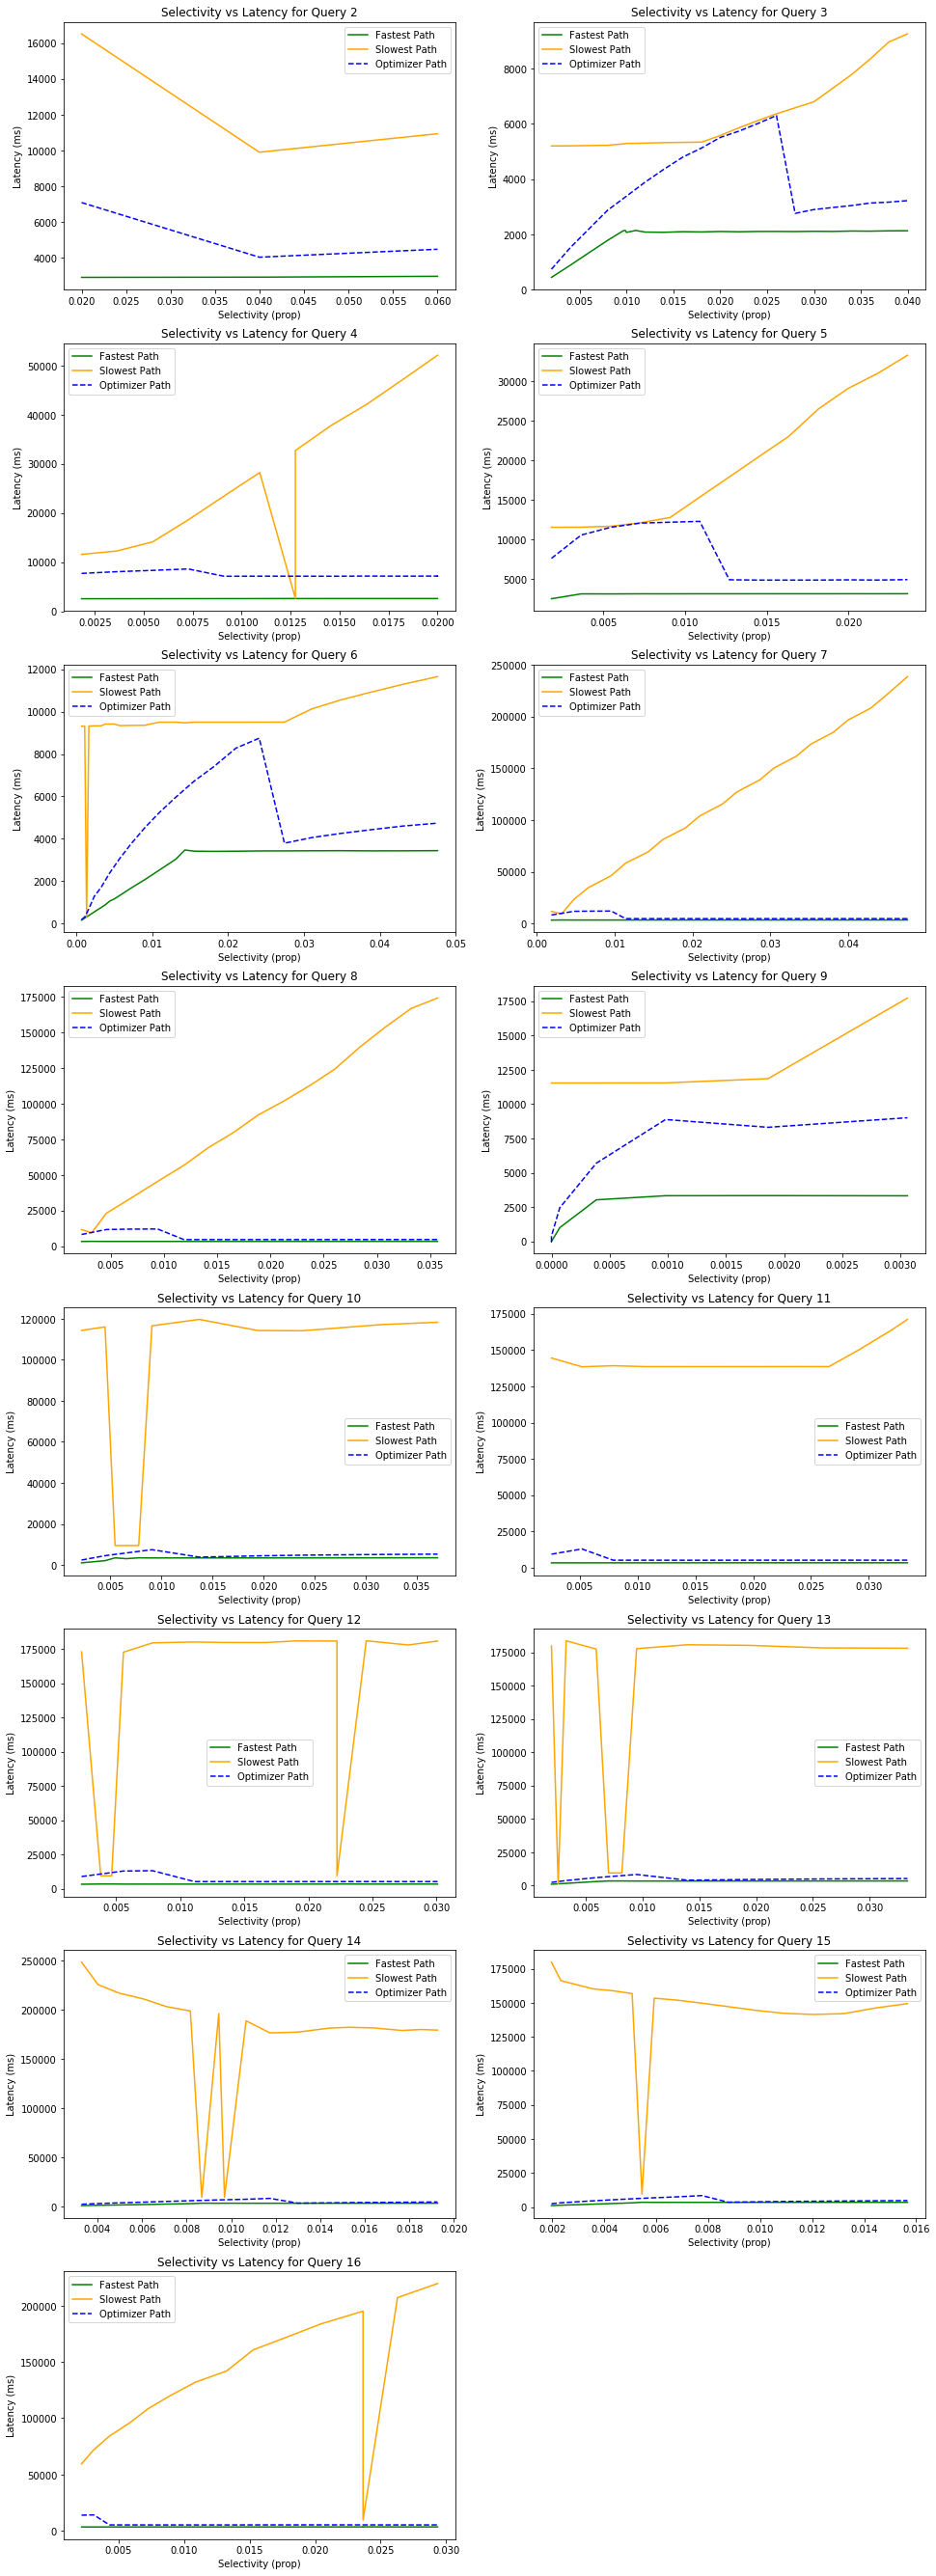

In [7]:
plot_fast_slow_optimizer(df_c5_fastest, df_c5_slowest, df_c5_opt)

First, you'll notice some outliers pulling the worst path toward optimal. Those are random queries I inserted using the hard-coded optimal to give more data to train on. For now, ignore those since they don't have a worst-case counterpart.

Of interest is that the optimizer rarely chooses the true optimal path. In fact, many times, it approaches the worst case. A horizontal line indicates a scan since the latency is constant because it scans the whole table. Notice that by about 1.5% selectivity, it's almost always optimal to scan the entire 60M rows. For some queries it's even sooner. Also, notice that the queries make a difference outside of selectivity (multiple columns in the predicate change wha the optimal path might be). A change of direction in the graph shows a change in decision (for example, stop using an index, or add a thread, etc).

## Comparing the servers

Is there a difference in hardware? Will they all make the same decisions?

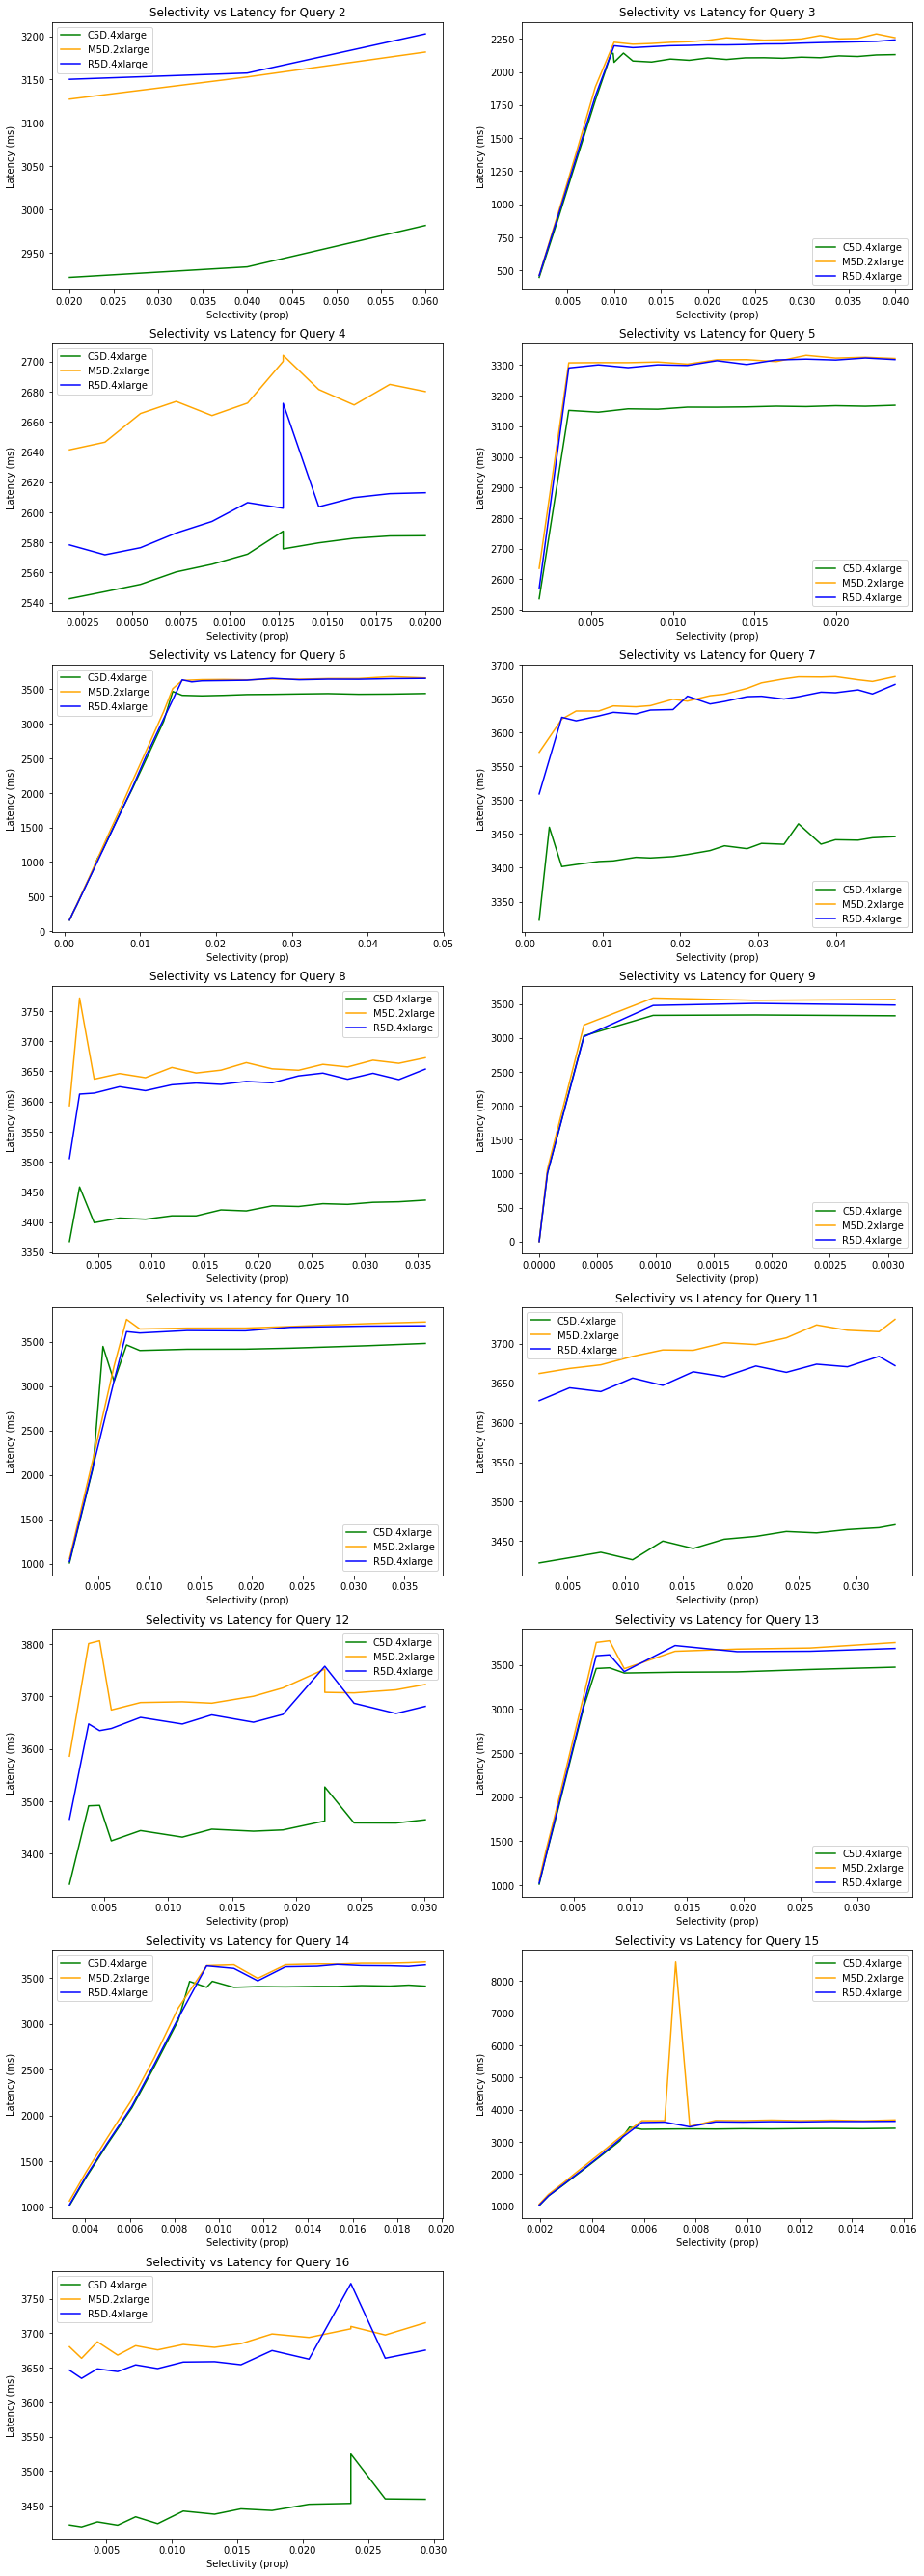

In [8]:
#Let's compare each of the servers to see if the best path () shifts
plot_servers(df_c5_fastest, df_m5_fastest, df_r5_fastest)

When a shape is the same, but shifted, it tells us the decision should be the same, the machine will just have different characteristics in performance (for example, Queries 5 & 6). However, when the shape changes (Query 1, 8, 16, etc.) it tells us that the system's capabilties change the _decision_ a system should make.

Let's see if the optimizer is sensisitive to that.

## Optimizers on various systems

Is the optimizer smart enough to see that the systems should have different paths?

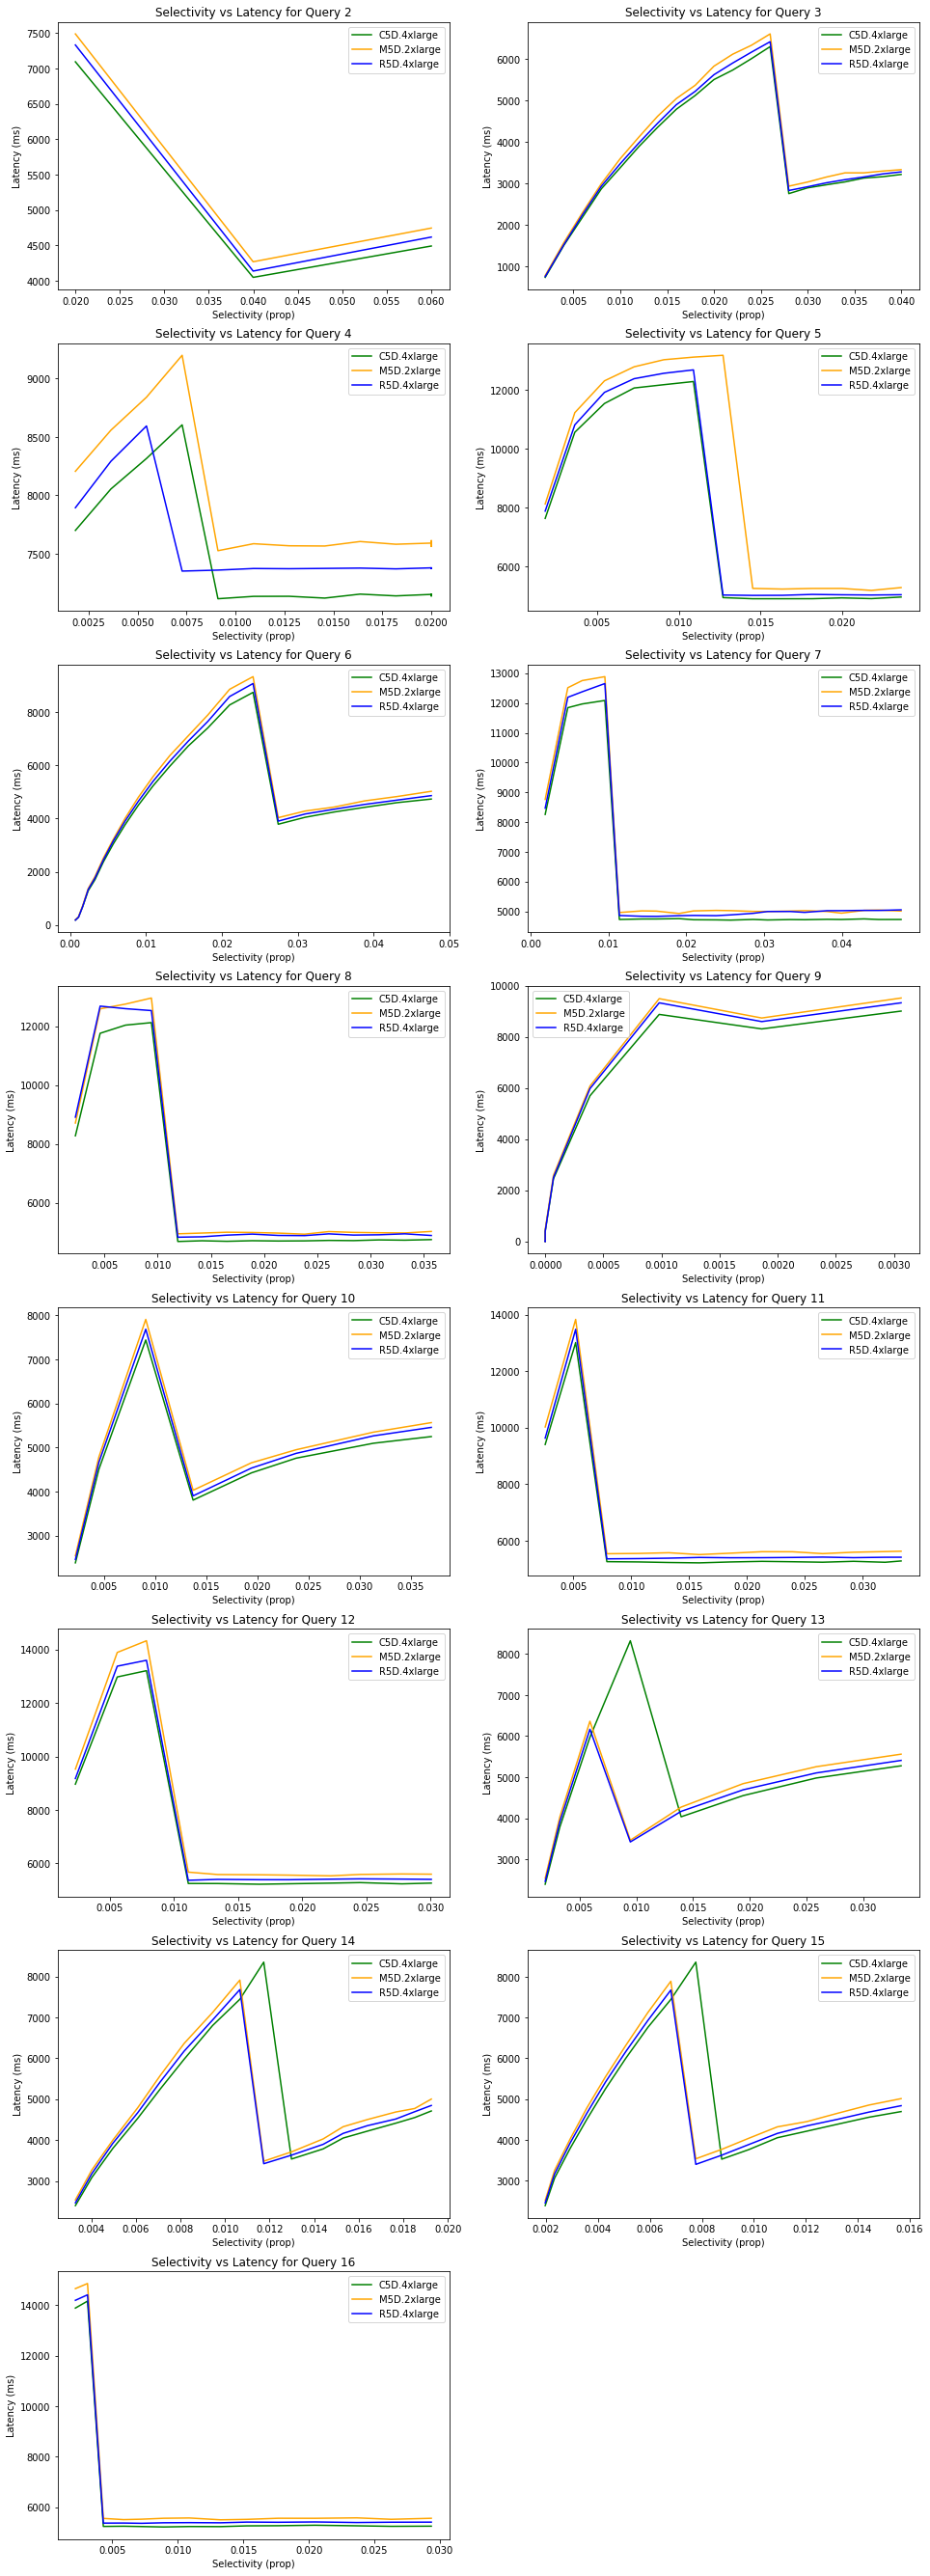

In [9]:
plot_servers(df_c5_opt, df_m5_opt, df_r5_opt)

Since the shapes look identical, it tells us that the optimizer makes the same decision each time (in other words, it does not take into account the various nuances of a system). That's a tall order since the optimizer would need to get more and more complicated as new hardware features are released. Granted, systems do implement the changes to help actual query performance (as shown in the variety of best paths above), it's not reflected in the optimizer (as shown here).

# Modeling

Now that we have some intuition, can we beat the optimizer with an AI-based approach?

For an in-depth discussion on the 10 architectures tested to find the optimal, see the Model-MLP notebook. I chose Architecture 9, which is described below. First, these are the feature vectors and the label is latency:

In [12]:
#these we want as-is. Either their already normalized, or they represent one-hot encoded values
X = df[['s_workers', 'idx_q','idx_e', 'idx_p', 'idx_s', 'idx_d',
       'h_numa', 'h_avx2',
       'h_avx512bw', 'h_avx512vl', 'h_avx512cd', 'h_avx512dq',
       'h_ss', 'h_3dnowprefetch', 'h_erms', 'h_bmi2',
       'h_invpcid', 'p_e','p_q', 'p_s', 'p_p',
       'p_d', 'p_e_o', 'p_s_o', 'p_d_o', 'p_p_o', 'p_q_o',
       'p_q_path_index', 'p_q_path_filter', 'p_q_path_bitmap',
       'p_s_path_index', 'p_s_path_filter', 'p_s_path_bitmap',
       'p_d_path_index', 'p_d_path_filter', 'p_d_path_bitmap',
       'p_p_path_index', 'p_p_path_filter', 'p_p_path_bitmap',
       'p_e_path_index', 'p_e_path_filter', 'p_e_path_bitmap',
       'p_p_op_eq', 'p_p_op_lt', 'p_p_op_gt', 'p_p_op_lte', 'p_p_op_gte',
       'p_q_op_eq', 'p_q_op_lt', 'p_q_op_gt', 'p_q_op_lte', 'p_q_op_gte',
       'p_e_op_eq', 'p_e_op_lt', 'p_e_op_gt', 'p_e_op_lte', 'p_e_op_gte',
       'p_s_op_eq', 'p_s_op_lt', 'p_s_op_gt', 'p_s_op_lte', 'p_s_op_gte',
       'p_d_op_eq', 'p_d_op_lt', 'p_d_op_gt', 'p_d_op_lte', 'p_d_op_gte']]

#we'll normalize these continuous values
X = pd.concat([X, tf.keras.utils.normalize(df[['h_mem', 'h_cores', 'h_clk', 'h_l1d', 'h_l1i', 'h_l2', 'h_l3', 
'h_bogomips', 'p_e_v', 'p_s_v', 'p_p_v', 'p_q_v', 'p_d_v']])], axis=1)

In [13]:
df[["latency"]].max()

latency    263911.285
dtype: float64

In [14]:
highest_val = df[["latency"]].max()
#Normalize the label, but do it in a way we can reverse it to make it interpretable.
# To reverse it, simply multiply by highest_val
Y = df[["latency"]]/highest_val

This design of this architecture is similar to the work in this paper: https://arxiv.org/pdf/1809.00677.pdf

There, they describe an architecure with alternating relu and linear dense layers. I chose to apply this to a similar architecture to an autoencoder (it starts big (128, which is greater than our input), gets smaller (to 64), then has the same number as outputs as inputs(128, again)). I ran tests to the "autoencoder style", which I called Architecture 7, and it performed well. This performed better.

It would make sense that this would work well because we're trying to find which features matter... and not all of them do. Decreasing the neurons and swapping activations will make the features that are more impactful stand out.

In [15]:
import keras
from keras.layers import Input, Dense
from keras.models import Model, Sequential

keras.backend.clear_session()

model = Sequential()

model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="linear"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="linear"))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="linear"))
model.add(Dense(1, kernel_initializer='normal')) 

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])

Using TensorFlow backend.


In [16]:
epochs = 100
cb = keras.callbacks.ModelCheckpoint("FinalModel.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

#we'll make the training not emit too much in the logs since we do this in another notebook and visualize it below
train_hist = model.fit(x=X.values, y=Y.values, epochs=epochs, shuffle=True, validation_split=.2, callbacks=[cb], verbose=1)

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               10368     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total para

In [111]:
#!brew install graphviz

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

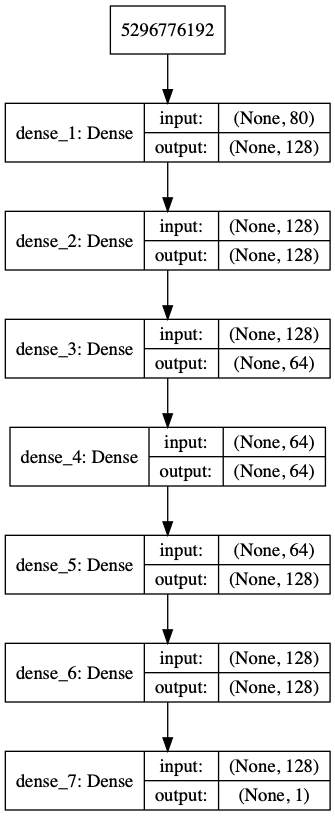

I chose to focus on MSE (mean squared error) and MAE (mean absolute error). MAE is a bit easier to interpret since it's already in the units of the label, but since I normalized the label, I'll need to convert it back to truly interpret it. For now, it still gives us an idea of how the model is performing.

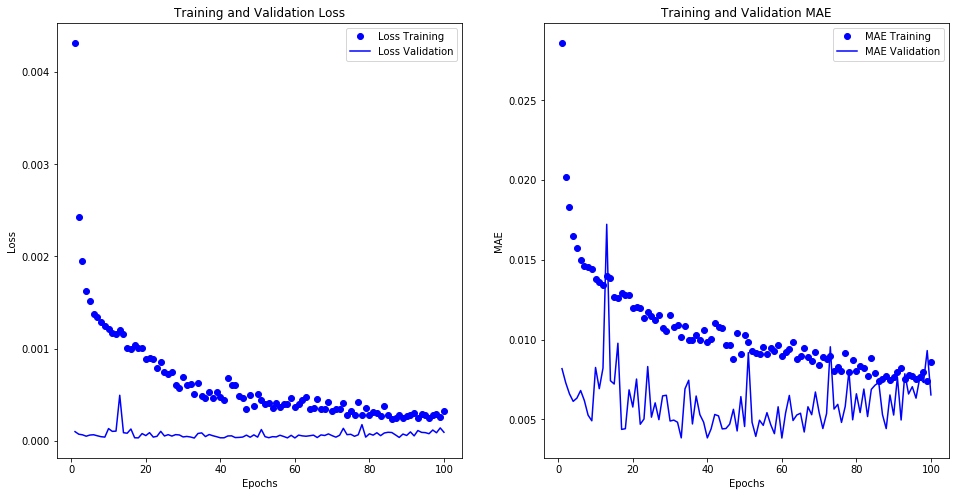

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(16)

x = range(1, epochs + 1)

#plot the loss as circles and the accuracy as a line
ax1.plot(x, train_hist.history['loss'], "bo", label="Loss Training")
ax1.plot(x, train_hist.history['val_loss'], "b", label="Loss Validation")

ax2.plot(x, train_hist.history['mean_absolute_error'], "bo", label="MAE Training")
ax2.plot(x, train_hist.history['val_mean_absolute_error'], "b", label="MAE Validation")


ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.set_title('Training and Validation MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.legend()

plt.show()

It's nice that the model looks like it's improving, but suppose that this became our new optimizer. How would it perform?

One way to gauge that is to predict the latencies of the same queries. Since we know the actual latencies, it would be easy to visually show us how well, or poorly the model's decisions were.

In [20]:
#First, get the predictions so we can interpret a plot...
df["predicted"] = model.predict(X)

In [21]:
#Now, we need to convert them back to milliseconds
df["predicted"] = df["predicted"].astype(float) * float(highest_val)

In [22]:
# Let's see what the fastest predictions are, then compare those to actuals
df_c5_pred  = find_best(df[df["info_ec2"] == "c5d.4xlarge"], "predicted")
df_m5_pred  = find_best(df[df["info_ec2"] == "m5d.2xlarge"], "predicted")
df_r5_pred  = find_best(df[df["info_ec2"] == "r5d.4xlarge"], "predicted")

The blue line represents the actual latency for path the optimizer would have taken, the green is the true fastest path from observation, and the red dashed line is the path our new NN-based optimizer would have taken.

## For C5D.4xlarge

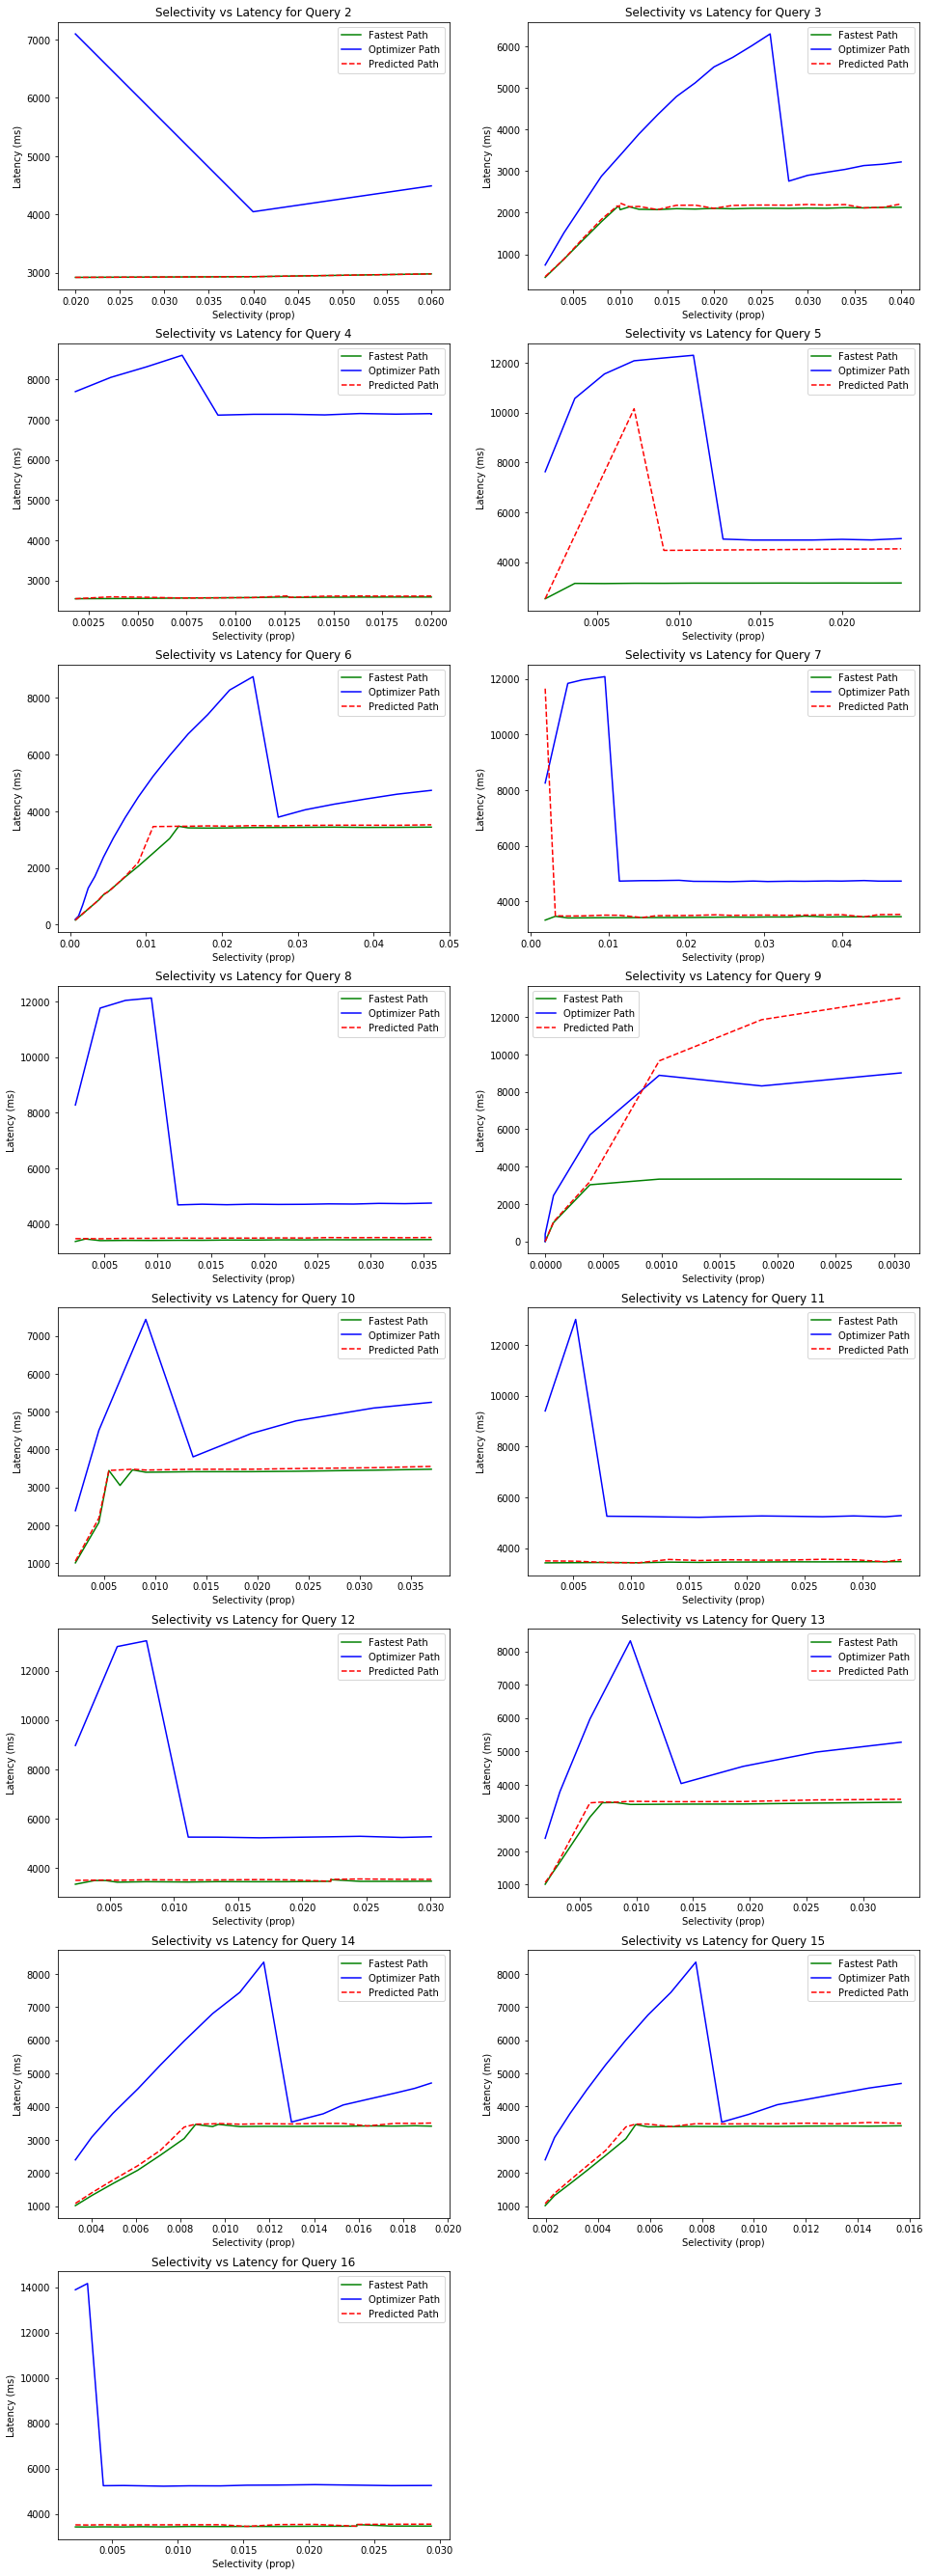

In [23]:
plot_fast_pred_opt(df_c5_fastest,df_c5_pred,df_c5_opt)

## For M5D.2xlarge

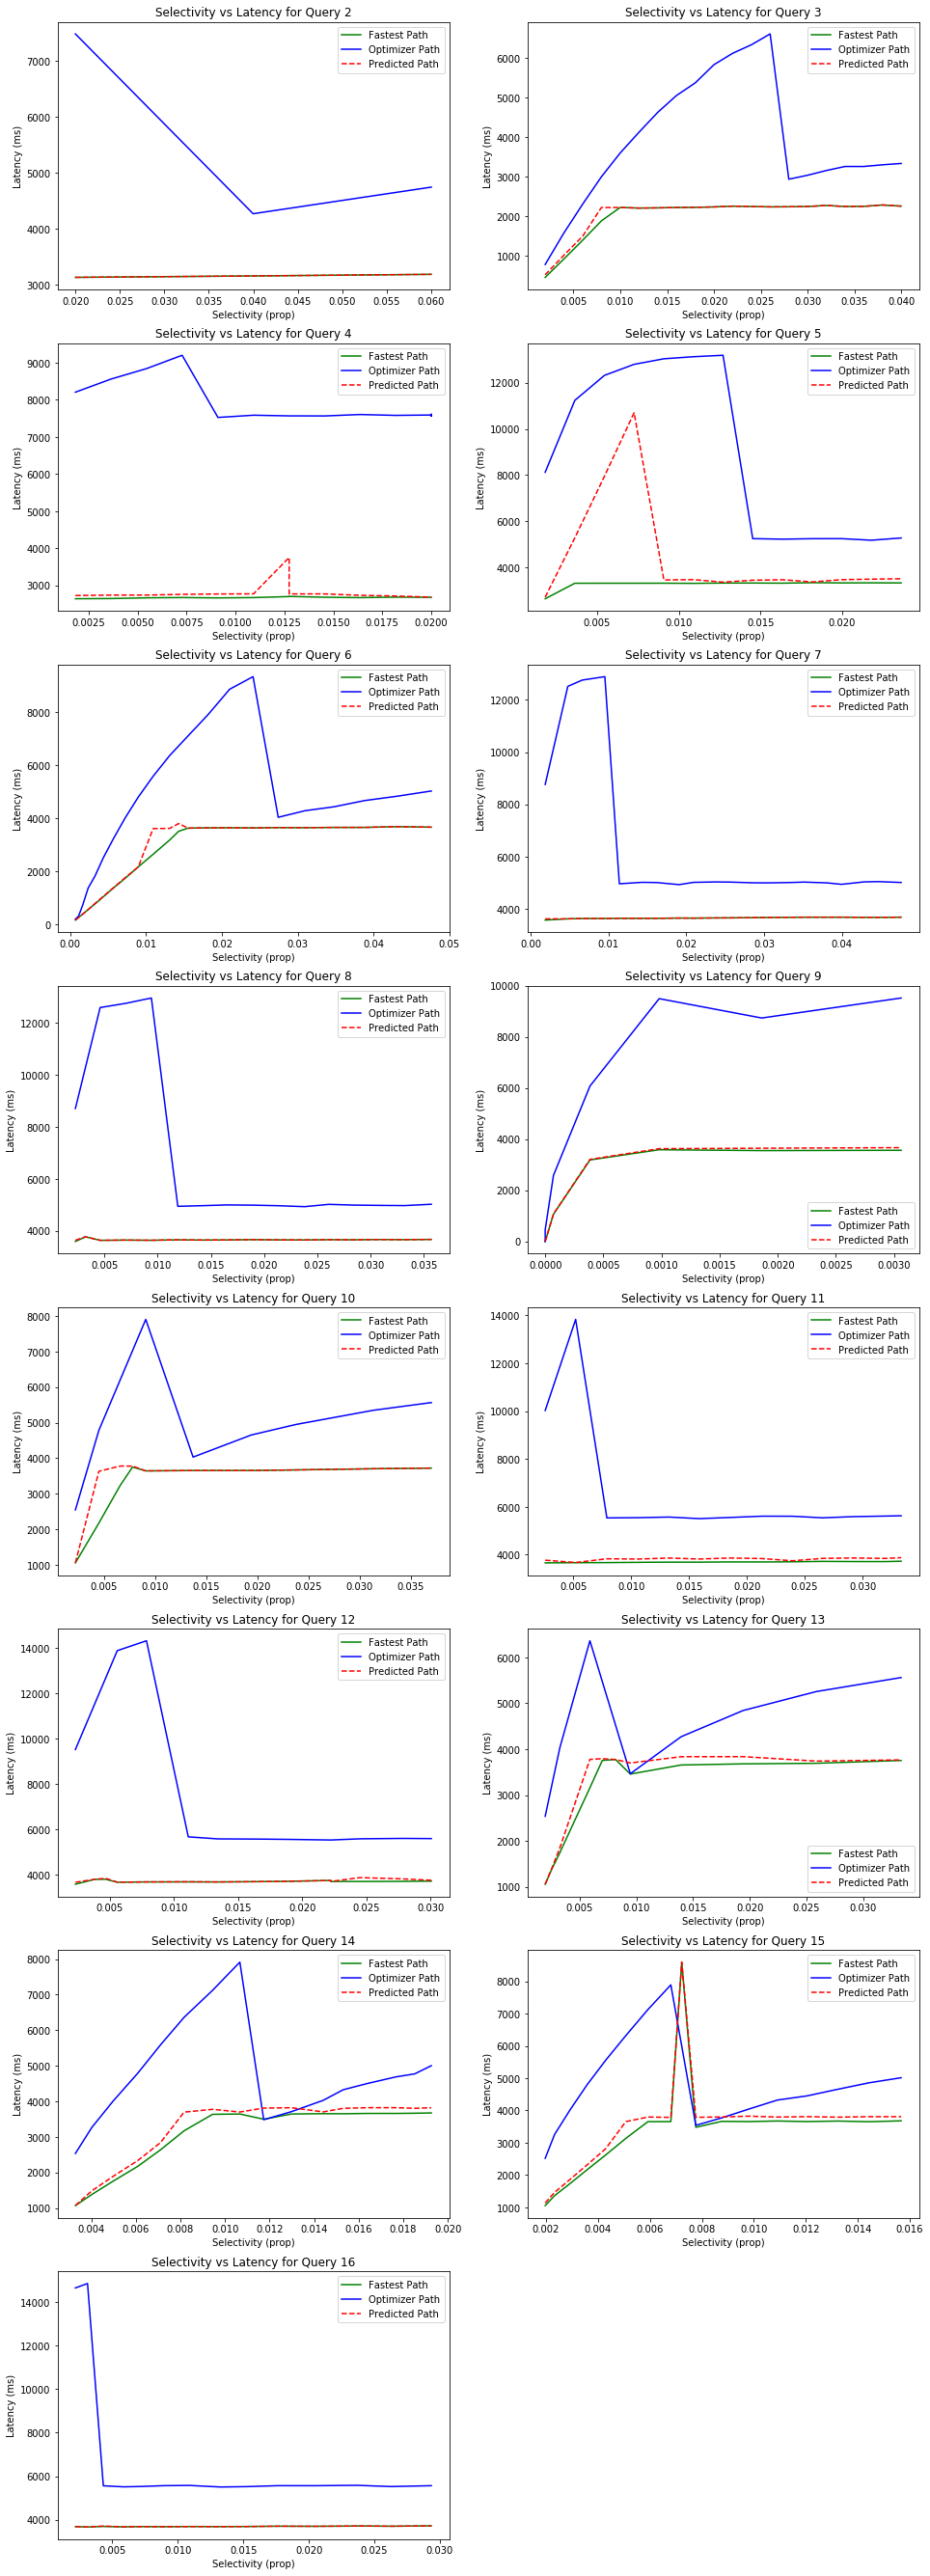

In [24]:
plot_fast_pred_opt(df_m5_fastest,df_m5_pred,df_m5_opt)

## For R5D.4xlarge

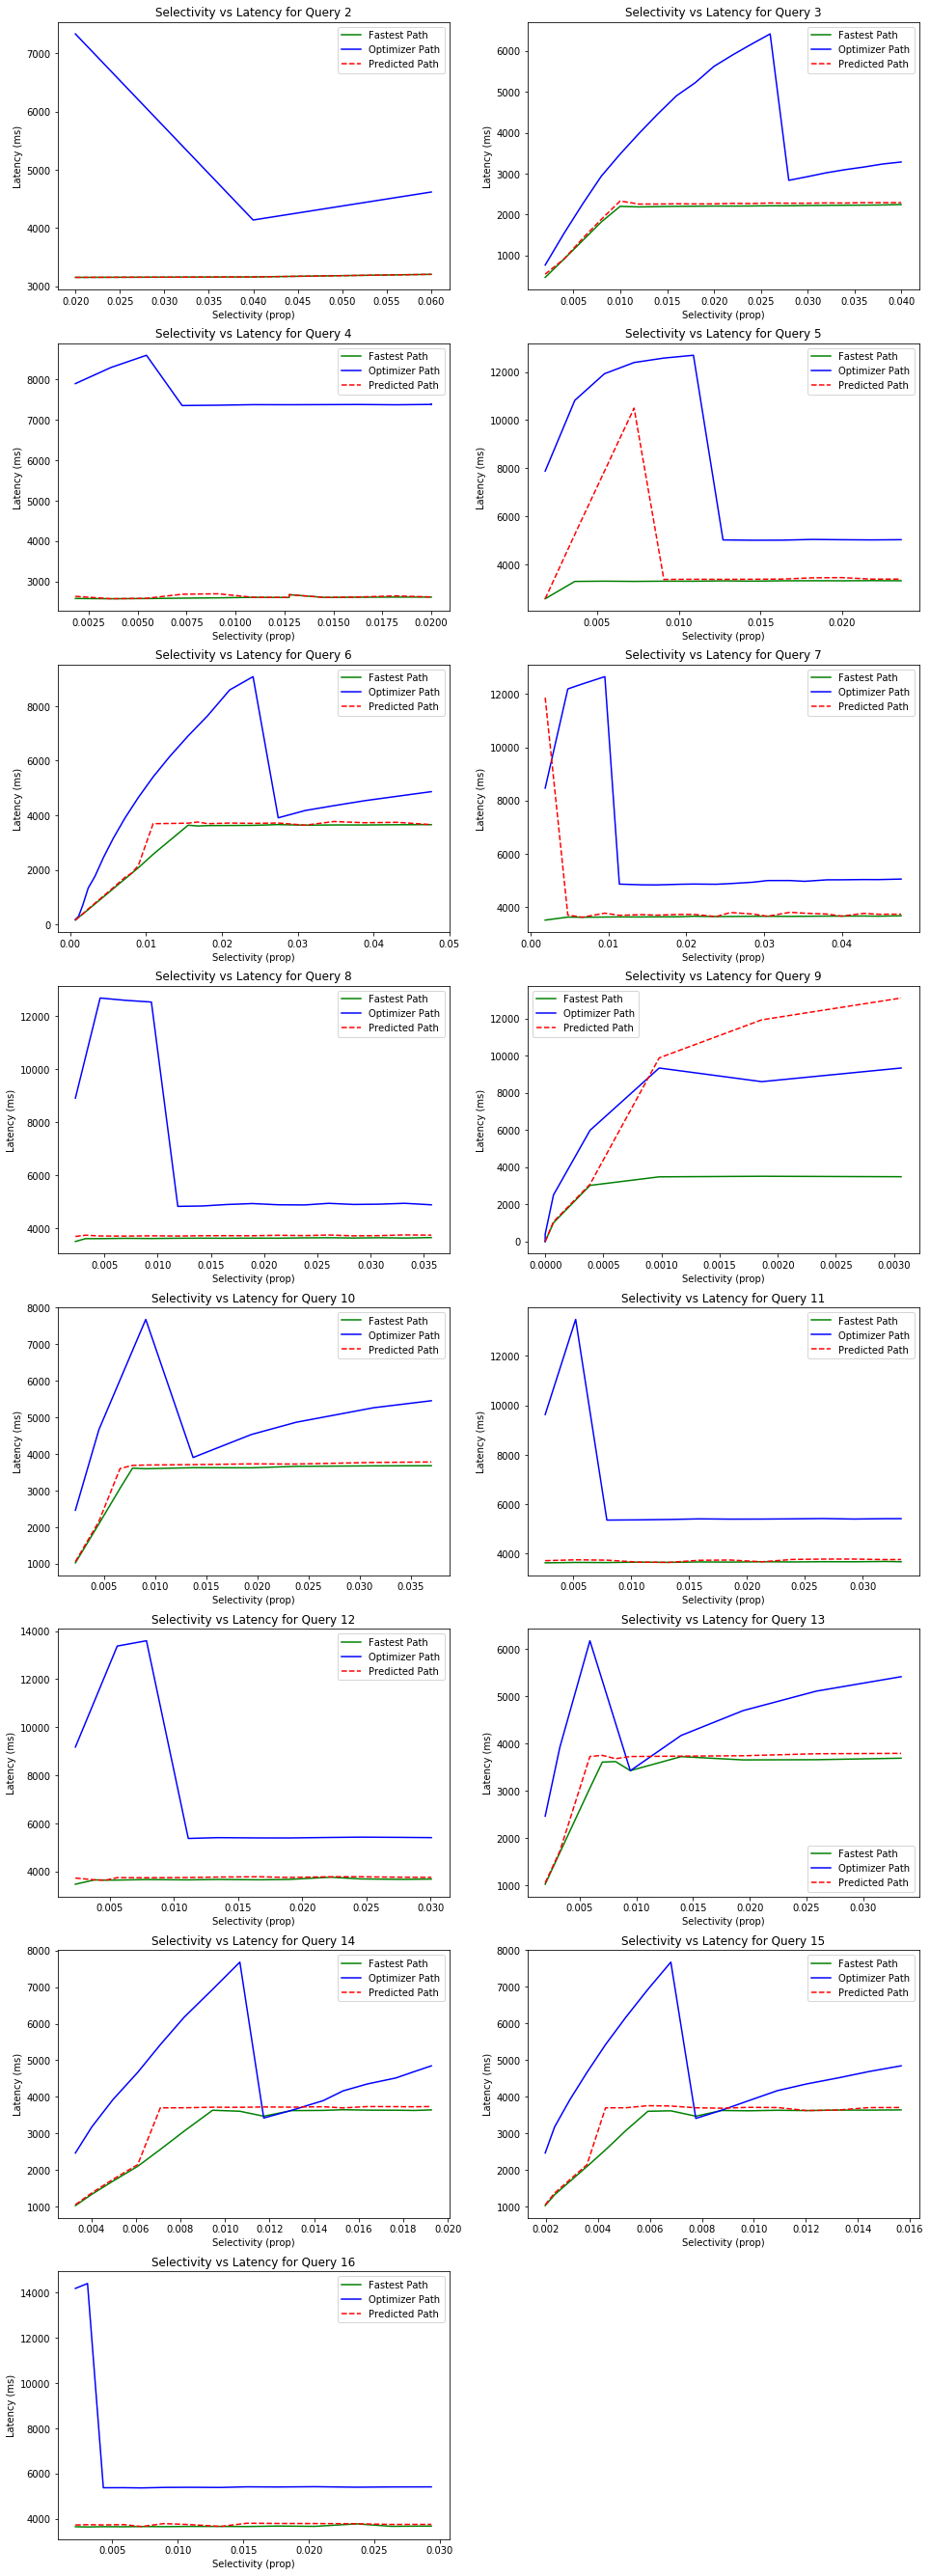

In [25]:
plot_fast_pred_opt(df_r5_fastest,df_r5_pred,df_r5_opt) 

Let's review the results query-by-query:

- 2, 8, 11, 12, 16: Our new optimizer chose the optimal path on all systems.
- 3, 10: Our new optimizer chose close to optimal, but on the M5D system, there was some confusion right around the path  change point.
- 4: We chose well on C5d and R5D, but made a mistake on a few points on M5D
- 5: Query 5 was a challenge (we tested an index on 2 columns and it incorrectly chose to use an index (and the wrong one) longer than it should have), but still a vast improvement over the optimizer on all cases.
- 6: The model chose to switch to early to scan, but still vastly improved over the optimizer.
- 7: On the compute (C5D) and memory optimized systems (R5D) it chose to give scan a try, when it really should never have.
- 9: It chose perfectly for the general system, but did not learn better on the compute and memory optimized systems.
- 13: It chose reasonably well. On M5D, out of sheer luck, the optimizer's choice ended up touching the optimal line (it doesn't on any other systems), and it just beats our model on one point.
- 14: Similar to Q13, but it happens on M5D and C5D.
- 15: Same as Q13, but we have a suspect data point on M5D.

Overall, the NN version outperformed the optimizer, but still struggled at the change point in certain scenarios. Perhaps with more data and more model engineering, we could get better. To be fair the change points are the difficult decision points, and we still perform reasonably well, even when we complicate things with many indexes, concurrency, and different technologies.

## Overfitting

Just a word about overfitting: In our case, it's not a terrible thing (it depends on what you are overfitting). We're not looking for predictive power on a system it's never seen before. We're looking to train a model on a system, and use it on queries we've never seen before. Those selectivity of those queries would absolutely fall within our model, but a huge system change would require retraining the model.